In [1]:
import os
os.getcwd()

'/home/onyxia/work/hackathon-un-2022/notebooks'

In [3]:
os.chdir("..")
import utils.functions as fc

In [169]:
from importlib import reload
fc = reload(fc)

In [5]:
ship_data_enriched = fc.create_ship_data_enriched()
AIS = fc.read_ais_parquet()
#AIS_enriched = fc.enrich_AIS_data(
#    AIS, ship_data_enriched
#)

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [7]:
AIS_enriched = fc.enrich_AIS_data(
    AIS, ship_data_enriched
)

In [8]:
AIS_enriched.drop_duplicates('mmsi').agg({"mmsi": "nunique"})

mmsi    1862
dtype: int64

In [9]:
fc.count_boats(AIS_enriched, unique_id = "mmsi")

mmsi    1862
dtype: int64

In [165]:
fc.count_boats(AIS_enriched, by = "ShiptypeLevel1")

ShiptypeLevel1
Cargo Carrying                 1331
Work Vessel                     510
Non Seagoing Merchant Ships       9
Non Merchant                      7
Non Propelled                     4
Non Ship Structure                1
dtype: int64

In [172]:
fc = reload(fc)
fc.count_boats(AIS_enriched, by = "ShiptypeLevel1")
fc.count_boats_blocked(AIS_enriched, var = "ShiptypeLevel1", share_not_usable=0.6)


,0
ShiptypeLevel1,
Cargo Carrying,532.4
Work Vessel,204.0
Ships blocked,1117.2


In [11]:
fc.count_boats(AIS_enriched, by = "ShipTypeLevel2")

ShipTypeLevel2
Dry Cargo/Passenger            719
Miscellaneous                  358
Tankers                        335
Bulk Carriers                  277
Fishing                        118
Offshore                        34
Non-Seagoing Merchant Ships      9
Non-Merchant Ships               7
Non-Propelled                    4
Non-Ship Structures              1
dtype: int64

In [12]:
fc.count_boats(AIS_enriched, by = "ShipTypeLevel3")

ShipTypeLevel3
General Cargo            591
Bulk Dry                 263
Towing / Pushing         257
Chemical                 159
Oil                      159
Fish Catching            105
Other Activities          64
Container                 57
Offshore Supply           27
Passenger                 26
Dredging                  18
Liquefied Gas             17
Ro-Ro Cargo               17
Other Fishing             13
Passenger/Ro-Ro Cargo     13
Other Dry Cargo           12
Research                  12
Bulk Dry / Oil            11
Other Offshore             7
Other activities           7
Yacht                      7
Tanker                     4
Barge                      4
Other Non-Seagoing         4
Refrigerated Cargo         3
Other Bulk Dry             3
Non-ship structures        1
Dry Cargo/Passenger        1
dtype: int64

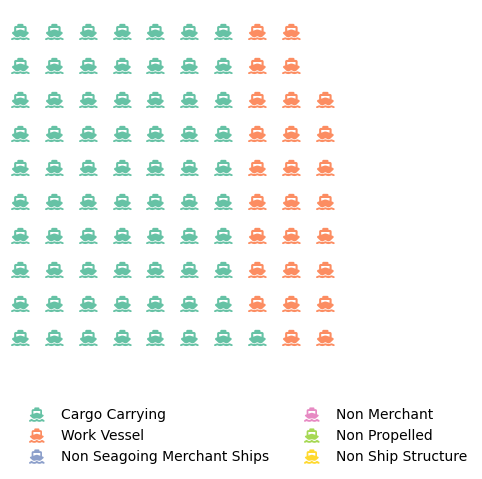

In [13]:
fig = fc.waffle_chart_zone(AIS_enriched, by = "ShiptypeLevel1")

In [181]:
df = fc.count_boats_blocked(
            AIS_enriched,
            share_not_usable=0.3,
            by="ShiptypeLevel1"
            )
df.index.nunique()

3

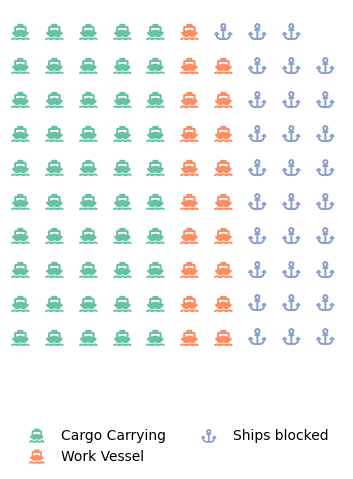

In [182]:
fc = reload(fc)
fig = fc.waffle_chart_zone(AIS_enriched, by = "ShiptypeLevel1", share_blocked=0.3)

In [17]:
import numpy as np
import geopandas as gpd
import folium

ports = fc.import_ports()

center, sw, ne = fc.bbox_geopandas(ports, "Latitude", "Longitude")

ports['map_color'] = np.where(ports["World Water Body"].str.contains("Black"), 'lightblue','red')
ports['text'] = ports["Main Port Name"]

In [105]:
m = folium.Map(location = center, tiles='Stamen Toner', zoom_start=6)

for i in range(0,len(ports)):
    folium.Marker(
        [ports.iloc[i]['Latitude'], ports.iloc[i]['Longitude']],
        popup=ports.iloc[i]['text'],
        icon=folium.Icon(color=ports.iloc[i]['map_color'], icon="ship")
        ).add_to(m)

In [15]:
#m

In [117]:
m = folium.Map(location = center, tiles='Stamen Toner', zoom_start=6)

temp = ports.loc[ports["Harbor Size"] == "Large"]

for i in range(0,len(temp)):
    folium.Marker(
        [temp.iloc[i]['Latitude'], temp.iloc[i]['Longitude']],
        popup=temp.iloc[i]['text'],
        icon=folium.Icon(color=temp.iloc[i]['map_color'], icon="ship")
        ).add_to(m)

In [119]:
#m

In [30]:
temp1 = fc.count_boats(AIS_enriched, by='ShiptypeLevel1').reset_index().assign(var='ShiptypeLevel1')
temp2 = fc.count_boats(AIS_enriched, by='ShipTypeLevel2').reset_index().assign(var='ShipTypeLevel2')
temp = pd.concat([temp1, temp2])

{0: {'Cargo Carrying': 931.6999999999999,
  'Work Vessel': 357.0,
  'Non Seagoing Merchant Ships': 6.3,
  'Non Merchant': 4.8999999999999995,
  'Non Propelled': 2.8,
  'Non Ship Structure': 0.7,
  'Ships blocked': 558.6}}

In [94]:
temp = fc.count_boats(AIS_enriched, by='ShiptypeLevel1').reset_index().assign(var='ShiptypeLevel1')

In [126]:
fc.count_boats(AIS_enriched, by='ShiptypeLevel1')#.to_dict()

ShiptypeLevel1
Cargo Carrying                 1331
Work Vessel                     510
Non Seagoing Merchant Ships       9
Non Merchant                      7
Non Propelled                     4
Non Ship Structure                1
dtype: int64

In [162]:
def count_boats_blocked(data, share_not_usable = 0.3, var='ShiptypeLevel1'):

    temp = fc.count_boats(AIS_enriched, by=var).reset_index()
    total = temp[0].sum()
    temp[0] = temp[0]*(1-share_not_usable)
    temp = pd.concat(
        [temp, pd.DataFrame(["Ships blocked"], columns=[var])]
    ).reset_index(drop=True)

    temp.loc[temp[temp.columns[0]] == "Ships blocked", 0] = total*share_not_usable

    temp = temp.loc[temp[0]/temp[0].sum()>0.01]
    classes = temp[var].nunique()
    temp = temp.set_index(var)
    
    return temp

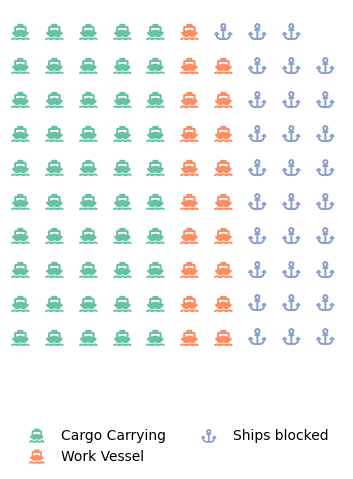

In [163]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

classes = temp[var].nunique()

fig = plt.figure(
        FigureClass=Waffle,
        rows=10,
        values=temp,
        columns=10, 
        icons=['ship']*(classes - 1) + ['anchor'],
        legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': 2, 'framealpha': 0},
        font_size=12,
        icon_legend=True
    )